<font color=gray>ADS Sample Notebook.

Copyright (c) 2021 Oracle, Inc. All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Model Deployment with the ADS</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team</font></p>

***

## Overview:

The `ads.model.deployment` SDK allows you to deploy models using the Oracle Cloud Infrastructure (OCI) Data Science service. This SDK is built on top of `oci` Python SDK with the goal of simplifying data science workflows.

The focus of this notebook is to demonstrate how to deploy a model using the data science friendly `ads.model.deployment` SDK. The notebook covers how to list, update and delete model deployments. It also demonstrates how to make a prediction using the deployed model and obtain the logs.


*** 

## Prerequisites:
- Experience with the topic: Basic
- Professional experience: Intermediate
- Setup OCI authentication with API key following api_keys.ipynb

***

## Objectives:
This notebook covers the following topics:
- <a href="#intro">Introduction</a>
  - <a href='#intro_md_components'>Model Deployment Components</a>
    - <a href='#intro_load_balancer'>Load Balancer</a>
    - <a href='#intro_model_catalog'>Model Catalog</a>
    - <a href='#intro_conda_env'>Conda Environment</a>
  - <a href='#intro_logging'>Logging Service</a>
- <a href='#setup'>Setup</a>
  - <a href='#setup_model'>Model Creation</a>
  - <a href='#setup_logging'>Setup Logging</a>
- <a href='#deploy'>Deploy a Model</a>
  - <a href='#deploy_mdp'>ModelDeploymentProperties</a>
  - <a href='#deploy_md'>ModelDeployer</a>
    - <a href='#deploy_with_mdp'>Deploy a Model with a `ModelDeploymentProperties` Object</a>
    - <a href='#deploy_without_mdp'>Deploy a Model without a `ModelDeploymentProperties` Object</a>
- <a href='#predict'>Make Predictions</a>
- <a href='#log_view'>Viewing the Logs</a>
- <a href='#deployment_info'>Information About a Model Deployment</a>
- <a href='#update'>Update a Model Deployment</a>
- <a href='#access_md'>Listing and Access Model Deployments</a>
  - <a href='#access_md_ocid'>Access a Model Deployment by OCID</a>
  - <a href='#access_md_list'>List Model Deployments</a>
- <a href='#delete'>Delete a Model Deployment</a>
- <a href='#ref'>References</a>


***

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

***

<font color=gray>Datasets are provided as a convenience.  Datasets are considered Third Party Content and are not considered Materials under your agreement with Oracle applicable to the Services.  You can access the `multiclass_fk_10k` dataset license [here](oracle_data/UPL.txt). Dataset `multiclass_fk_10k` is distributed under UPL license.</font>

In [ ]:
import ads
import json
import logging
import oci
import os
import random
import shutil
import string
import tempfile
import uuid
import warnings

from ads.catalog.model import ModelCatalog
from ads.common.model import ADSModel
from ads.dataset.factory import DatasetFactory
from oci.data_science import models
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from sklearn.ensemble import RandomForestClassifier

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')
ads.set_documentation_mode(False)
logging.getLogger('ads').setLevel(level=logging.ERROR)
logging.getLogger('ADS').setLevel(level=logging.ERROR)
logging.getLogger('ODSC-ModelDeployment').setLevel(level=logging.ERROR)

<a id="intro"></a>
# Introduction

Model deployments are a managed resource in the Oracle Cloud Infrastructure (OCI) Data Science service that allows you to deploy machine learning models as HTTP endpoints. Deploying machine library models as web applications (HTTP API endpoints) serving predictions in real-time is the most common way that models are productized. HTTP endpoints are flexible and can serve requests for model predictions.

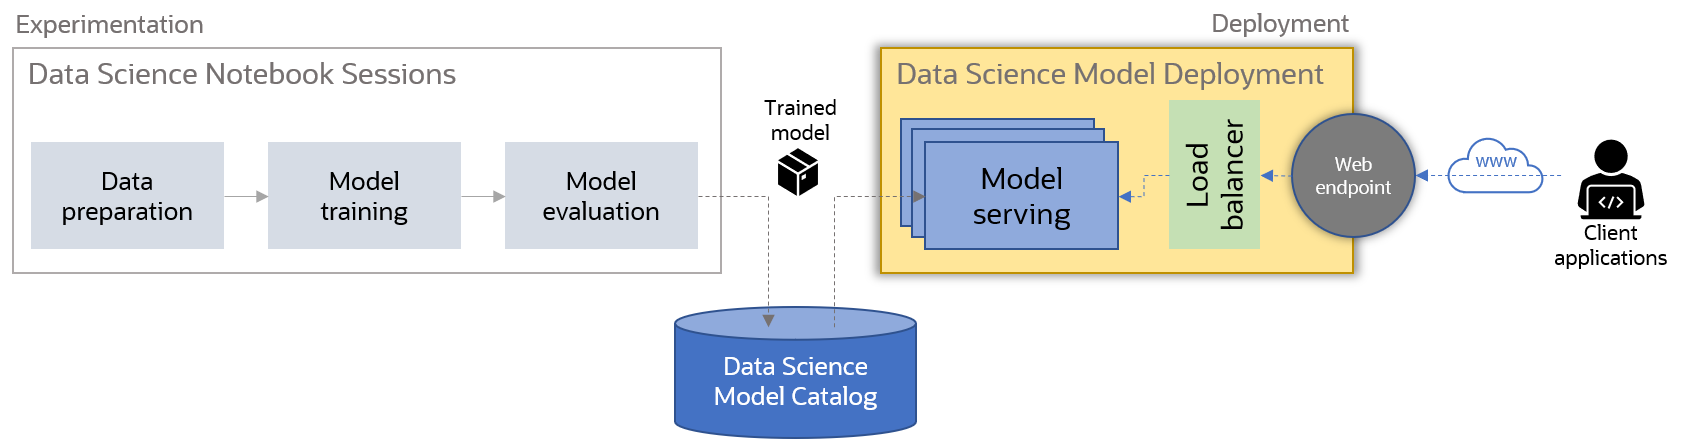

You train a model and store it in the model catalog. Then you deploy the model using the model deployment resource.

After a model is saved to the model catalog, it becomes available for deployment as a Model Deployment resource. The service supports models running in a Python runtime environment and their dependencies can be packaged in a conda environment. This notebook demonstrates how to deploy a model using the data scientist friendlier `ads.model.deployment` SDK.

Model deployment requires that you specify an inference conda environment in the [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml) model artifact file. This inference conda environment contains all your model dependencies and is installed in the model server container. You can specify either a service or customer-managed conda environment.

<a id='intro_md_components'></a>
## Model Deployment Components

Model deployments rely on these key components to deploy a model as an HTTP endpoint:

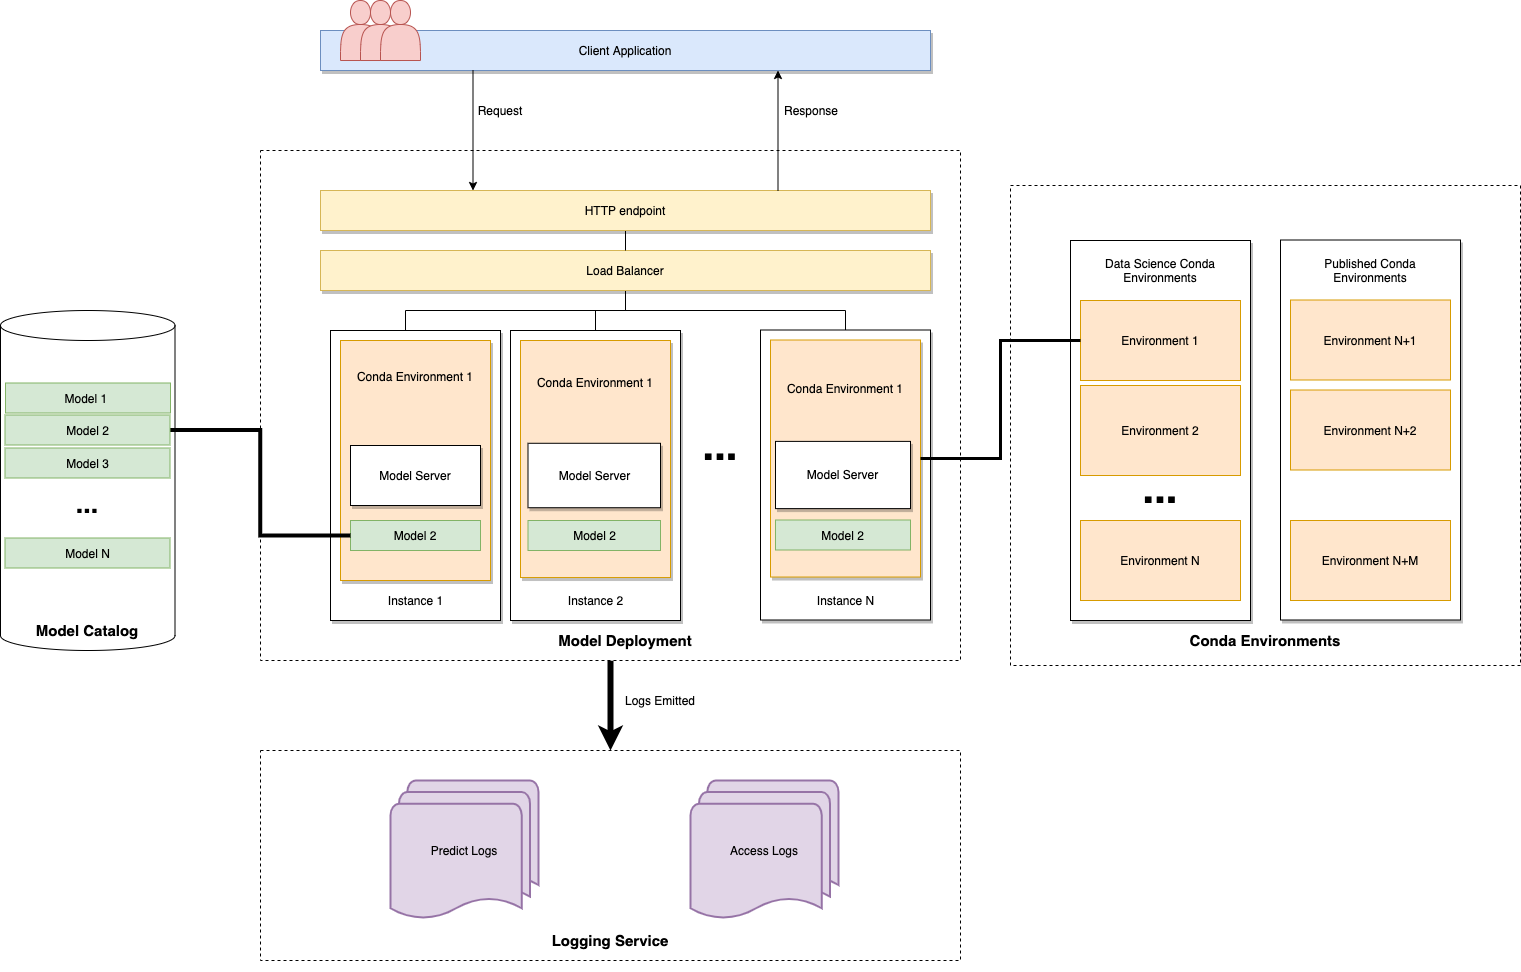

<a id='intro_load_balancer'></a>
### Load Balancer

The load balancer provides an automated way to distribute traffic from one entry point to multiple model servers running in a pool of virtual machines (VMs). The bandwidth of the load balancer must be specified in Mbps and is a static value. You can change the load balancer bandwidth by editing the model deployment.

A pool of VM instances hosting the model server, the conda environment, and the model itself. A copy of the model server is made to each compute instance.

A copy of the inference conda environment and the selected model artifact are also copied to each instance in the pool. Two copies of the model are loaded to memory for each OCPU of each VM instance in the pool. For example, if you select a VM.Standard2.4 instance to run the model server, then 4 OCPUs x 2 = 8 copies of the model are loaded to memory. Multiple copies of the model help to handle concurrent requests that are made to the model endpoint by distributing those requests among the model replicas in the VM memory. Ensure that select a VM shape with a large enough memory footprint to account for those model replicas in memory. For most machine learning models with sizes in MBs or the low GBs, this should not be an issue.

The load balancer distributes requests made to the model endpoint among the instances in the pool. We recommend that you use smaller VM shapes to host the model with a larger number of instances as opposed to selecting fewer though larger VMs.

<a id='intro_model_catalog'></a>
### Model Catalog

Model deployment requires a [model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models) that is stored in the model catalog and that the model is in an active state. Model deployment exposes the `predict()` function defined in the [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py) file of the model artifact.

<a id='intro_conda_env'></a>
### Conda Environment

A conda environment encapsulates all the third-party Python dependencies (like Numpy, Dask, or XGBoost) that your model requires. Model deployment pulls a copy of the inference conda environment defined in the [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml) file of the model artifact to deploy the model and its dependencies. The relevant information about the model deployment environment is under the `MODEL_DEPLOYMENT` parameter in the [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml) file.

In this example, the [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml) file instructs the model deployment to pull the published conda environment from the Object Storage path defined by `INFERENCE_ENV_PATH`. It then installs it on all instances of the pool hosting the model server and the model itself.

If you do not want to use a customer-managed conda environment, the alternative is to use a service-managed conda environment with `INFERENCE_ENV_TYPE = 'data_science'` with the path on Object Storage available in the Environment Explorer tool or in included conda environments.

```
MODEL_ARTIFACT_VERSION: '3.0'
MODEL_DEPLOYMENT:
INFERENCE_CONDA_ENV:
INFERENCE_ENV_SLUG: envslug
INFERENCE_ENV_TYPE: published
INFERENCE_ENV_PATH: oci://<bucket-name>@<namespace>/<prefix>/<env>
INFERENCE_PYTHON_VERSION: '3.8'
```

These parameters are automatically captured when a model is saved using ADS in a notebook session. If you want to save a model to the catalog and deploy it using the `oci` SDK, CLI, or the Console, you have to provide a `runtime.yaml` file as part of your model artifact that includes those parameters.

If `MODEL_DEPLOYMENT` is missing from the `runtime.yaml` file, then a default conda environment is used and installed in the model server and is used to load your model. The default conda environment is the [Classic CPU Notebook Session Kernel (version 1.0)](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/conda_cpu_vm_shapes.htm#classic-cpu-notebook-session-kernel) .

For all model artifacts saved in the catalog without a `runtime.yaml` file, model deployments also use the default [Classic CPU Notebook Session Kernel (version 1.0)](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/conda_cpu_vm_shapes.htm#classic-cpu-notebook-session-kernel) conda environment for model deployment. A model deployment can also pull a Data Science conda environment or a conda environment that you create or modify then publish.

<a id='intro_logging'></a>
### Logging Service
Model deployment can be integrated with the [OCI Logging service](https://docs.oracle.com/en-us/iaas/Content/Logging/Concepts/loggingoverview.htm). This option allows you to emit logs from a model and then inspect these logs.

<a id='setup'></a>
# Setup

To do a model deployment you will need a model. Optionally, the [OCI Logging service](https://docs.oracle.com/en-us/iaas/Content/Logging/Concepts/loggingoverview.htm) can be configured to allow the model deployment to emit logs. In this section, a toy random forest model will be created and stored in the model catalog. This is the model that is deployed. The notebook will also set up a connection to the logger so that logs can be emitted.

<a id='setup_model'></a>
## Model Creation

The next cell will use the `oracle_classification_dataset1_150K.csv` dataset to create a random forest model. This model is stored in the model catalog.

In [ ]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']

# Load the dataset
ds_path = os.path.join("/", "opt", "notebooks", "ads-examples", "oracle_data", 
                       "multiclass_fk_10k.csv")
ds = DatasetFactory.open(ds_path, target="Labels")
ds = ds.drop(['F1', 'F2', 'F3', 'F4', 'F5'], axis=1)

# Build the model and convert it to an ADSModel object
train, test = ds.train_test_split(test_size=0.15)
clf = RandomForestClassifier(n_estimators=10).fit(train.X.values, train.y.values)
model = ADSModel.from_estimator(clf)

# Prepare the model artifacts
artifact_path = tempfile.mkdtemp()
artifact_model = model.prepare(artifact_path, force_overwrite=True, 
                                     data_sample=test, data_science_env=True)

# Store the model in the Model Catalog
mc_model = artifact_model.save(project_id=project_id, compartment_id=compartment_id, 
                               display_name="RF Classifier", 
                               description="A sample Random Forest classifier", 
                               ignore_pending_changes=True)
shutil.rmtree(artifact_path)
model_id = mc_model.id
print(f"Model OCID: {model_id}")

<a id='setup_logging'></a>
## Setup Logging

The [Oracle Cloud Infrastructure Logging service](https://docs.oracle.com/en-us/iaas/Content/Logging/Concepts/loggingoverview.htm) is a highly scalable and managed service for logging. Logging provides logs from Oracle Cloud Infrastructure (OCI) resources such as model deployment. For model deployment, there is support for logging the access to the model deployment and predictions that are made.

Log groups are logical containers for logs. Generally, you will have a log group that will contain logs for access and predictions on a deployed model. The access and prediction log are custom logs.

The next cell will create a log group along with the custom access and prediction logs.

In [ ]:
# Generate a random log group and log name
log_group_name = "ModelDeployment-Demo-" + str(uuid.uuid4())
access_log_name = "ModelDeployment-Demo-Access_Log-" + str(uuid.uuid4())
predict_log_name = "ModelDeployment-Demo-Predict_Log-" + str(uuid.uuid4())

# Create a log group
response = !oci logging log-group create --compartment-id=$compartment_id --display-name=$log_group_name --wait-for-state SUCCEEDED --wait-for-state FAILED
data = json.loads("".join(response[1:]))
log_group_ocid = data.get("data").get("resources")[0].get("identifier")
print(f"Log group OCID: {log_group_ocid}")

# Create an access log in the log group
response = !oci logging log create --log-group-id=$log_group_ocid --log-type=CUSTOM --display-name=$access_log_name --wait-for-state SUCCEEDED --wait-for-state FAILED
data = json.loads("".join(response[1:]))
access_log_ocid = data.get("data").get("resources")[0].get("identifier")
print(f"Access log OCID: {access_log_ocid}")

# Create a predict log in the log group
response = !oci logging log create --log-group-id=$log_group_ocid --log-type=CUSTOM --display-name=$predict_log_name --wait-for-state SUCCEEDED --wait-for-state FAILED
data = json.loads("".join(response[1:]))
predict_log_ocid = data.get("data").get("resources")[0].get("identifier")
print(f"Predict log OCID: {predict_log_ocid}")

<a id='deploy'></a>
# Deploy a Model

This section demonstrates how to use the `ads.model.deployment` SDK to deploy a model. The `ads.model.deployment` SDK is designed for data science workflows. 

The `ads.model.deployment` SDK provides three classes for model deployment to simplify the process:
* `ads.model.deployment.ModelDeploymentProperties`: Stores the properties mapping to OCI model deployment models.
* `ads.model.deployment.ModelDeployer`: Create a new deployment, list existing deployments, get/update/delete an existing deployment.
* `ads.model.deployment.ModelDeployment`: Encapsulates the information and actions for an existing deployment.

<a id='deploy_mdp'></a>
## ModelDeploymentProperties

The `ModelDeploymentProperties` class acts as a container to store model deployment properties. This class requires the model OCID. String properties are set with the `with_prop()` method. Use it to chain together properties such and the display name, project OCID and compartment OCID. The `with_access_log()` and `with_predict_log()` methods define the logging properties. Or use the `with_logging_configuration()` method to define the predict and access log properties as a single method. The `with_instance_configuration()` method defines the instance shape, count and bandwidth.

In [ ]:
# Initialize ModelDeploymentProperties
model_deployment_properties = ModelDeploymentProperties(
    model_id
).with_prop(
    'display_name', "Model Deployment Demo using ADS"
).with_prop(
    "project_id", project_id
).with_prop(
    "compartment_id", compartment_id
).with_logging_configuration(
    log_group_ocid, access_log_ocid, log_group_ocid, predict_log_ocid
).with_instance_configuration(
    config={"INSTANCE_SHAPE":"VM.Standard2.1", "INSTANCE_COUNT":"1",'bandwidth_mbps':10}
)

<a id='deploy_md'></a>
## ModelDeployer

The `ModelDeployer` class is used to deploy a model. Behind the scenes it does a number of steps for you such as fetching the default OCI config setting, initialize the `DataScienceClient`, `DataScienceCompositeClient` and `LogSearchClient` objects. Authentication can be through API keys or Resource Principals.

The `deploy()` method is used to create a model deployment. In addition, it has these parameters that control the behavior of the deployment:
* `max_wait_time`: The timeout limit for the deployment process to wait until it is active. Defaults to 1200 seconds.
* `poll_interval`: The interval, in seconds, between checks of the deployment status. Defaults to 30 seconds.
* `wait_for_completion`: Blocked process until the deployment has completed. Defaults to True.

There are two ways to use the `deploy()` method. You can create a `ModelDeploymentProperties` object and pass that in. Or you can define the model deployment properties in the `deploy()` method.

<a id='deploy_with_mdp'></a>
### Deploy a Model with a `ModelDeploymentProperties` Object

Once a `ModelDeploymentProperties` object has been created, let us call that `model_deployment_properties`, a model can be deployed with this code snippet:

```python
deployer = ModelDeployer()
deployment = deployer.deploy(model_deployment_properties)
```
<a id='deploy_without_mdp'></a>
### Deploy a Model without a `ModelDeploymentProperties` Object

Depending on your use case, it may be more convenient to skip the creation of a `ModelDeploymentProperties` object and create the model deployment directly with the `deploy()` method. This is done by passing the using keyword arguments instead of `ModelDeploymentProperties`. To do this, the model deployment properties are specified as parameters in the `deploy()` method.

To define the model deployment properties with the following parameters:
* `access_log_group_id`: Log group OCID for the access logs. Required if `access_log_id` is specified.
* `access_log_id`: Custom logger OCID for the access logs. Required if `access_log_group_id` is specified.
* `bandwidth_mbps`: The bandwidth limit, in Mbps, on the load balancer. Optional.
* `compartment_id`: Compartment OCID that the model deployment will belong to.
* `defined_tags`: A dictionary of defined tags to be attached to the model deployment. Optional.
* `description`: A human-friendly description of the model deployment. Optional.
* `display_name`: A human-friendly name to identify the model deployment.
* `freeform_tags`: A dictionary of freeform tags to be attached to the model deployment. Optional.
* `instance_count`: The number of instances that are to be deployed.
* `instance_shape`: The instance shape to use. For example, "VM.Standard2.1"
* `model_id`: Model OCID that is used in the model deployment.
* `predict_log_group_id`: Log group OCID for the predict logs. Required if `predict_log_id` is specified.
* `predict_log_id`: Custom logger OCID for the predict logs. Required if `predict_log_group_id` is specified.
* `project_id`: Project OCID that the model deployment will belong to.

In [ ]:
deployer = ModelDeployer()
deployment = deployer.deploy(
    model_id=model_id,
    display_name="Model Deployment Demo using ADS",
    instance_shape="VM.Standard2.1",
    instance_count=1,
    project_id=project_id,
    compartment_id=compartment_id,
    # The following are optional
    access_log_group_id=log_group_ocid,
    access_log_id=access_log_ocid,
    predict_log_group_id=log_group_ocid,
    predict_log_id=predict_log_ocid
)

deployment_id = deployment.model_deployment_id
print(f"Deployment {deployment_id} is {deployment.state.name}")

<a id='predict'></a>
# Make Predictions

Predictions can be made by calling the HTTP end-point for the model deployment. The `ModelDeployment` object has an attribute `url` that specifies the end-point. It is also possible to use the `ModelDeployment` object with the `predict()` method. The format of the data that is passed to the HTTP end-point depends on the setup of the model artifact. The default setup is to pass it a Python dictionary that has been converted to a JSON data structure. The first level defines the feature names. The second level uses an identifier for the observation (i.e. row in the data frame) and the value associated with it. Assume that the model has features F1, F2, F3, F4, and F5. In this example, the observations are identified by the values 0, 1, and 2. Thus, the data would look like this:

|Index|F1|F2|F3|F4|F5|
|:- |:-|:-|:-|:-|:-|
| 0|11|12|13|14|15|
| 1|21|22|23|24|25|
| 2|31|32|33|34|35|

The JSON would become:

```json
{ 'F1': { 0: 11, 1: 21, 2: 31},
'F2': { 0: 12, 1: 22, 2: 32},
'F3': { 0: 13, 1: 23, 2: 33},
'F4': { 0: 14, 1: 24, 2: 34},
'F5': { 0: 15, 1: 25, 2: 35}
}
```

The next cell uses the first three rows of the `test` data frame and the `ModelDeployment` object to call the HTTP end-point. The returned result is the predictions for the three observations.

In [ ]:
deployment.predict(test.X.iloc[[0, 1, 2], :].to_dict())

<a id='log_view'></a>
# Viewing the Logs

The `show_logs()` method in the `ModelDeployment` class provides access to the predict and access logs. This method returns a data frame where each row represents a log entry. The parameter `log_type` accepts 'predict' and 'access' to specify which logs to return. If it is not specified, the access logs are returned. The parameters `time_start` and `time_end` restrict the logs to time periods between those entries. The parameter `limit` limits the number of log entries that are returned.

*note*: Logs are not collected in real-time. The following cell may result in no output. This is expected behavior. If the cell is run sometime later, it should show output.

In [ ]:
deployment.show_logs(log_type="access", limit=10)

The `logs()` method has the same arguments as `show_logs()` but returns the data as a list of dictionaries.

*note*: Logs are not collected in real-time. The following cell may result in no output. This is expected behavior. If the cell is run sometime later, it should show output.

In [ ]:
deployment.logs(log_type="access", limit=1)

<a id='deployment_info'></a>
# Information About a Model Deployment

The `ModelDeployment` class has a number of attributes that provide information about the deployment. The `properties` attribute contains information about the model deployment's properties by exposing a `ModelDeploymentProperties` object. This object has all of the attributes of the [OCI `ModelDeplolyment` model](https://oracle-cloud-infrastructure-python-sdk.readthedocs.io/en/latest/api/data_science/models/oci.data_science.models.ModelDeployment.html#oci.data_science.models.ModelDeployment). The most commonly used properties are:

* `category_log_details`: An OCI model object that contains the OCIDs for the access and predict logs.
* `compartment_id`: Compartment ID of the model deployment.
* `created_by`: OCID of the user that created the model deployment.
* `defined_tags`: System defined tags.
* `description`: Human-readable description of the model deployment.
* `display_name`: Human readable display name.
* `freeform_tags`: User-defined tags.
* `model_id`: OCID of the deployed model.
* `project_id`: OCID of the project the model deployment belongs to.

In [ ]:
print(f"Compartment OCID: {deployment.properties.compartment_id}\n" +
      f"Project OCID: {deployment.properties.project_id}\n" +
      f"Model OCID: {deployment.properties.model_id}\n" +
      f"Deployment Name: {deployment.properties.display_name}\n")


The `model_deployment_id` of the `ModelDeployment` class specifies the OCID of the model deployment.

In [ ]:
deployment.model_deployment_id

The URL of the model deployment that is to be used to make predictions using an HTTP request is given in the `url` attribute of the `ModelDeployment` class. You can make HTTP requests to this end-point to have the model make predictions. See the <a href="#predict">Make Predictions</a> section and the [Invoking a Model Deployment](https://docs.oracle.com/en-us/iaas/data-science/using/model-dep-invoke.htm) documentation for details. 

In [ ]:
deployment.url

The state of the model deployment can be determined by the `current_state.name` attribute. It will have values such as 'ACTIVE', 'INACTIVE' and, 'FAILED'.

In [ ]:
deployment.current_state.name

The `list_workflow_logs()` provides a list of dictionaries that define the steps that were used to deploy the model.

In [ ]:
deployment.list_workflow_logs()

<a id='update'></a>
# Update a Model Deployment

The `update()` method of the `ModelDeployment` class is used to make changes to a deployed model. This method accepts the same parameters as the `deploy()` method. See the <a href='#deploy_without_mdp'>Deploy a Model without a `ModelDeployment` Object</a> section of a list of model configurations that can be changed. One difference between the `update()` and `deploy()` methods is that all parameters are optional. Therefore, you only need to specify the parameters that you wish to change.

A common use case is to change the underlying model that is deployed. To do this you would run a command like:

```python
deployment.update(model_id="ocid1.datasciencemodel.oc1.iad.amaaaaaav66vvnia26bxl42pdxgzzz....")
```

In the next cell, the display name of the model will be updated.

In [ ]:
print(f"Orginal Display Name: {deployment.properties.display_name}")
deployment.update(display_name="")
print(f"New Display Name: {deployment.properties.display_name}")

<a id='access_md'></a>
# Listing and Access Model Deployments

When a model deployment is created, a `ModelDeployment` is returned. However, if a model is deployed then you need a method to access a `ModelDeployment` object associated with the model deployment of interest. The `get_model_deployment()` method creates a `ModelDeployment` object when the model deployment OCID is known. The `list_deployments()` method returns a list of `ModelDeployment` objects.

<a id='access_md_ocid'></a>
## Access a Model Deployment by OCID

If the model deployment OCID is known then the `get_model_deployment()` method of the `ModelDeployer` class can be used to obtain a `ModelDeployment` object.

The next cell creates a new `ModelDeployment` object that has access to the model deployment created in this notebook.

In [ ]:
existing_deployment = deployer.get_model_deployment(model_deployment_id=deployment_id)
print(f"deployment OCID: {deployment.model_deployment_id}\n" +
      f"existing deployment OCID: {existing_deployment.model_deployment_id}")

The `get_model_deployment_state()` method of the `ModelDeployer` class accepts a model deployment ODIC and returns a State enum. This is a convenience method to obtain the model deployment state when the model deployment OCID is known. The next cell returns the state of the model deployed in this notebook.

In [ ]:
deployer.get_model_deployment_state(model_deployment_id=deployment_id).name

<a id='access_md_list'></a>
## List Model Deployments

The `list_deployments()` method of the `ModelDeployer` class returns a list of `ModelDeployment` objects. The optional parameter `compartment_id` limits the search to a specific compartment. By default, it uses the same compartment that the notebook is in. The optional parameter `status` will limit the returned `ModelDeployment` objects to those model deployments that have the specified status. Values for the `status` parameter would be 'ACTIVE', 'INACTIVE' or 'FAILED'.

The next cell will obtain a list of active deployments in the compartment specified by `compartment_id` and print the display name.

In [ ]:
for active_deployment in deployer.list_deployments(status="ACTIVE", compartment_id=compartment_id):
    print(active_deployment.properties.display_name)

The `show_deployments()` method is a helper function that works the same way as the `list_deployments()` method except it returns a data frame of the results.

In [ ]:
deployer.show_deployments(compartment_id=compartment_id, status="ACTIVE")

<a id='delete'></a>
# Delete a Model Deployment

The `odsc` SDK provides two methods for deleting a model deployment. The `ModelDeployer` class has a static method `delete()`. This method can also be accessed on a `ModelDeployer` object. For example, this notebook has a variable `deployer` which is a `ModelDeployer` object. A model deployment can be deleted with:

```python
deployer.delete(model_deployment_id=deployment_id)
```
or equivalently,
```python
ModelDeployer.delete(model_deployment_id=deployment_id)
```

If you have a `ModelDeployment` object, there is a `delete()` method that will delete the model that is associated with that object. The optional parameter `wait_for_completion` accepts a boolean and determines if the process is blocking or not.

The next cell will use a `ModelDeployment` object to delete the model deployment that was created in this notebook.

In [ ]:
deployment = deployment.delete(wait_for_completion=True)

When a model deployment is deleted, it deletes the load balancer instances associated with it. If logging was configured, it does not delete that log group or loggers. In addition, the model in the model catalog is not deleted. In the next cell, these resources will be removed.

In [ ]:
# Delete the log group and logs
logging_client = oci.logging.LoggingManagementClient(config=oci.config.from_file())
logging_client.delete_log(log_group_ocid, access_log_ocid)
logging_client.delete_log(log_group_ocid, predict_log_ocid)
logging_client.delete_log_group(log_group_ocid)

# Delete the model
ModelCatalog(compartment_id=compartment_id).delete_model(model_id)

<a id='ref'></a>
# References
* [Classic CPU Notebook Session Kernel (version 1.0)](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/conda_cpu_vm_shapes.htm#classic-cpu-notebook-session-kernel)
* [Oracle Cloud Infrastructure Logging service](https://docs.oracle.com/en-us/iaas/Content/Logging/Concepts/loggingoverview.htm)
* [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
* [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
* [model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)